In [6]:
from generate_samples import SyntheticDAG
import torch
import numpy as np
import pandas as pd
import time
import csv
import gc
from stein import Stein_hess_mat
from scipy.spatial.distance import pdist, squareform
from fast_stein import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from causal_peeler_e import *


In [2]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix


In [3]:
def noise_estimation(id_layers, layers):
    noise_estimates = np.zeros_like(id_layers)
    noise_estimates[:,0] = id_layers[:,0]
    upstream=[0]
    for layer in layers[1:]:
        for i in layer:
            degree = 2  # Degree of the polynomial features
            poly_features = PolynomialFeatures(degree=degree)
            X_poly = poly_features.fit_transform(id_layers[:,upstream])
            model = LinearRegression()
            model.fit(X_poly, id_layers[:,i])
            noise_estimates[:,i] = id_layers[:,i] - model.predict(X_poly)
        upstream+=layer
    return noise_estimates

In [4]:
def mac(noises, noises_estimates):
    correlation_coeffs = []
    for col in range(noises.shape[1]):
        correlation_matrix = np.corrcoef(noises[:, col], noises_estimates[:, col])
        # print(correlation_matrix)
        correlation_coeff = correlation_matrix[0, 1]
        correlation_coeffs.append(abs(correlation_coeff))
    return np.mean(correlation_coeffs)

In [5]:
eta_G=0.10911070444147038
eta_H=0.9033964848783047
layers = [[0], [1], [2], [3]]
DAG_type = 'line'
num_latent = 4
num_samples = 1000000
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

In [27]:
graph = SyntheticDAG(num_latent, DAG_type)

In [28]:
U,X,noises = graph.sample_scaled(G, num_samples)
X = X.detach()

In [30]:
selected_indices = torch.randperm(X.size(0))[:5000]
X_tr = X[selected_indices]

In [33]:
id_layers = identify_e(X, X_tr, estimator='ssm')
noise_estimates = noise_estimation(id_layers, layers)

Starting...
-----------------------------------------------------------
Removing Layer 1.
-----------------------------------------------------------
Calculating Jacobian Estimates...


In [1]:
model = low_rank_s2()

NameError: name 'low_rank_s2' is not defined

In [34]:
def heuristic_kernel_width(X):
    X_diff = X.unsqueeze(1)-X
    D = torch.norm(X_diff, dim=2, p=2)
    s = D.flatten().median()
    return s

def heuristic_kernel_width_gpu(X, batch_size=50000):
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    X = X.to(device)

    n = X.size(0)
    distances = []

    # Process in smaller batches to avoid out-of-memory errors
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        for j in range(0, n, batch_size):
            end_j = min(j + batch_size, n)
            with torch.no_grad():
                D_batch = torch.cdist(X[i:end_i], X[j:end_j], p=2)
                distances.append(D_batch.cpu().flatten())  # Move to CPU and flatten
                del D_batch  # Ensure memory is freed immediately
                torch.cuda.empty_cache()  # Clear the cache to free memory

    # Concatenate all distances on the CPU
    distances = torch.cat(distances)
    s = distances.median().item()  # Compute the median
    return s

def heuristic_kernel_width_cpu(X):
    # Move X to CPU for scipy operations
    X_cpu = X.cpu().numpy()
    
    # Using scipy to compute pairwise distances efficiently
    D = pdist(X_cpu, 'euclidean')
    s = np.median(D)
    
    return torch.tensor(s, dtype=torch.float32)

In [35]:
torch.median(torch.cdist(X, X, p=2).flatten())

tensor(0.6945)

In [41]:
U,X,noises = graph.sample_scaled(G, 5000)
X = X.detach()

print(heuristic_kernel_width(X))
print(heuristic_kernel_width_gpu(X))
print(heuristic_kernel_width_cpu(X))
print(torch.median(torch.cdist(X, X, p=2).flatten()))

tensor(0.5864)
0.5863832831382751
tensor(0.5865)
tensor(0.5864)


In [42]:
n,d = X.shape
s = heuristic_kernel_width(X.detach())
X_diff = X.unsqueeze(1)-X
start = time.time()
# K = torch.exp(-torch.norm(X_diff, dim=2, p=2)**2 / (2 * s**2)) /s # /s ?
K = torch.exp(-torch.cdist(X, X, p=2)**2 / (2 * s**2)) /s
nablaK = -torch.einsum("kij,ik->kj", X_diff, K) / s**2

In [45]:
G = torch.matmul(torch.inverse(K + eta_G * torch.eye(n)), nablaK)
G_ = torch.linalg.solve(K + eta_G * torch.eye(n), nablaK)

G-G_

tensor([[ 0.3155,  0.2027,  0.3047,  0.1095],
        [-0.0519,  0.0184,  0.0121,  0.0750],
        [-0.1267, -0.1346, -0.0487,  0.2934],
        ...,
        [-0.0191,  0.0010, -0.0220, -0.0505],
        [ 0.0041,  0.0119,  0.0049, -0.0364],
        [-0.0052,  0.0238, -0.0092, -0.0515]])

/tmp/ipykernel_1282540/3305954931.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1282540/3305954931.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_upper = smoothed_upper.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1282540/3305954931.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_lower = smoothed_lower.fillna(method='bfill').fillna(method='ffill')


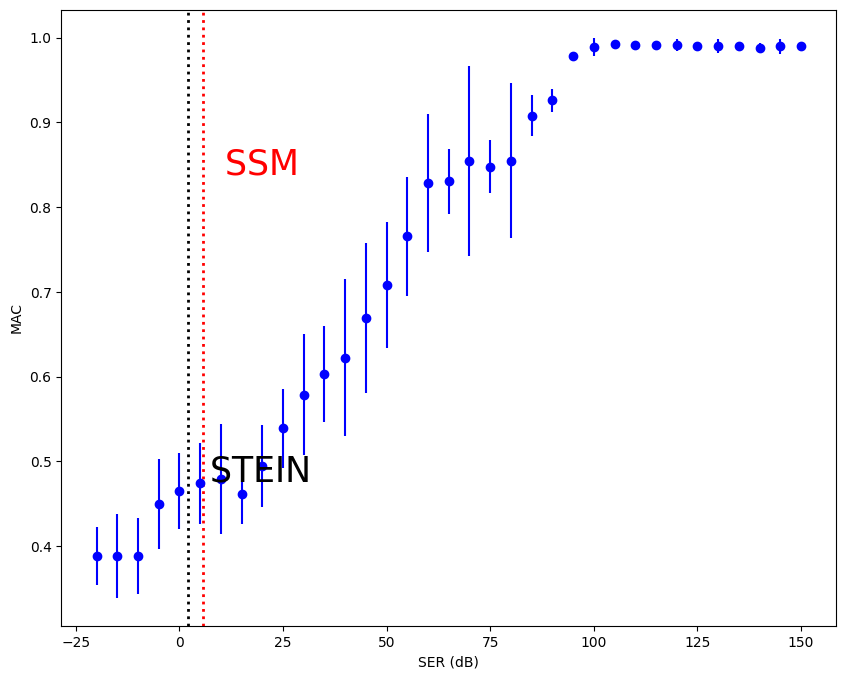

In [18]:
df = pd.read_csv('tests/SER_test.csv')
SER = df.iloc[:, 0]
MAC_measurements = df.iloc[:, 1:] 

MAC_mean = MAC_measurements.mean(axis=1)
MAC_std = MAC_measurements.std(axis=1)
MAC_se = MAC_std / np.sqrt(MAC_measurements.shape[1])

# Number of points in the moving average window
window_size = 4

# Compute the moving averages
smoothed_MAC_mean = MAC_mean.rolling(window=window_size, center=True).mean()
smoothed_upper = (MAC_mean + MAC_se).rolling(window=window_size, center=True).mean()
smoothed_lower = (MAC_mean - MAC_se).rolling(window=window_size, center=True).mean()

# Handling NaN values that may appear at the start/end due to the rolling mean
smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill').fillna(method='ffill')
smoothed_upper = smoothed_upper.fillna(method='bfill').fillna(method='ffill')
smoothed_lower = smoothed_lower.fillna(method='bfill').fillna(method='ffill')

# Plotting
plt.figure(figsize=(10, 8))
plt.errorbar(SER, smoothed_MAC_mean, yerr=MAC_se, fmt='o', color='blue', label='MAC vs. SER')
# plt.plot(SER, smoothed_MAC_mean, label='Smoothed MAC') #, cmap='PuBu')
# plt.fill_between(SER, smoothed_lower, smoothed_upper, color='blue', alpha=0.3, label='Confidence Interval')

y_lower, y_upper = plt.ylim()
ssm_location = 5.6768695599372725  # the x-coordinate where the line should be drawn
plt.axvline(x=ssm_location, color='red', linestyle=':', linewidth=2)
y_mid_h = y_lower + 0.75 * (y_upper - y_lower)
plt.text(ssm_location, y_mid_h, '  SSM', color='red', verticalalignment='center', horizontalalignment='left', fontsize=25)

stein_location = 2.0122194828233173
plt.axvline(x=stein_location, color='black', linestyle=':', linewidth=2)
y_mid_l = y_lower + 0.25 * (y_upper - y_lower)
plt.text(stein_location, y_mid_l, '  STEIN', color='black', verticalalignment='center', horizontalalignment='left', fontsize=25)

# plt.title('Smoothed MAC vs SER')
plt.xlabel('SER (dB)')
plt.ylabel('MAC')
plt.grid(False)
# plt.legend()

plt.show()